In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [4]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['BsmtFinType2_BLQ', 'BsmtQual_Fa', 'MasVnrType_BrkCmn', 'BsmtExposure_Gd', 'OverallQual_8', 'MSSubClass_160', 'PavedDrive_N', 'KitchenQual_Ex', 'MSZoning_RH', 'LotShape_IR3', 'ExterQual_Ex', 'OverallCond_6', 'SaleType_COD', 'Fence_GdPrv', 'Exterior1st_Plywood', 'Condition2_RRAn', 'LotShape_IR2', 'Heating_Grav', 'MSSubClass_45', 'Neighborhood_SWISU', 'Neighborhood_OldTown', 'Utilities_AllPub', 'BsmtExposure_No', 'BldgType_2fmCon', 'Exterior1st_AsbShng', 'LotConfig_Corner', 'Condition1_RRNe', 'HeatingQC_Ex', 'OverallCond_5', 'Electrical_Mix', 'RoofStyl

In [5]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [6]:
df[cat_features].describe()

,BsmtFinType2_BLQ,BsmtQual_Fa,MasVnrType_BrkCmn,BsmtExposure_Gd,OverallQual_8,MSSubClass_160,PavedDrive_N,KitchenQual_Ex,MSZoning_RH,LotShape_IR3,...,GarageType_BuiltIn,Neighborhood_CollgCr,Exterior2nd_Wd Sdng,Functional_Mod,Neighborhood_StoneBr,OverallCond_3,HeatingQC_Gd,Exterior2nd_Stucco,GarageCond_Fa,MiscFeature_Shed
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.022603,0.023973,0.010274,0.091781,0.115068,0.043151,0.061644,0.068493,0.010959,0.006849,...,0.060274,0.102740,0.134932,0.010274,0.017123,0.017123,0.165068,0.017808,0.023973,0.033562
std,0.148684,0.153016,0.100873,0.288815,0.319214,0.203266,0.240590,0.252677,0.104145,0.082505,...,0.238075,0.303723,0.341767,0.100873,0.129775,0.129775,0.371370,0.132299,0.153016,0.180160
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print (df.shape)

(1460, 320)


In [8]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0)    

In [9]:
print (df.shape)

(1460, 320)


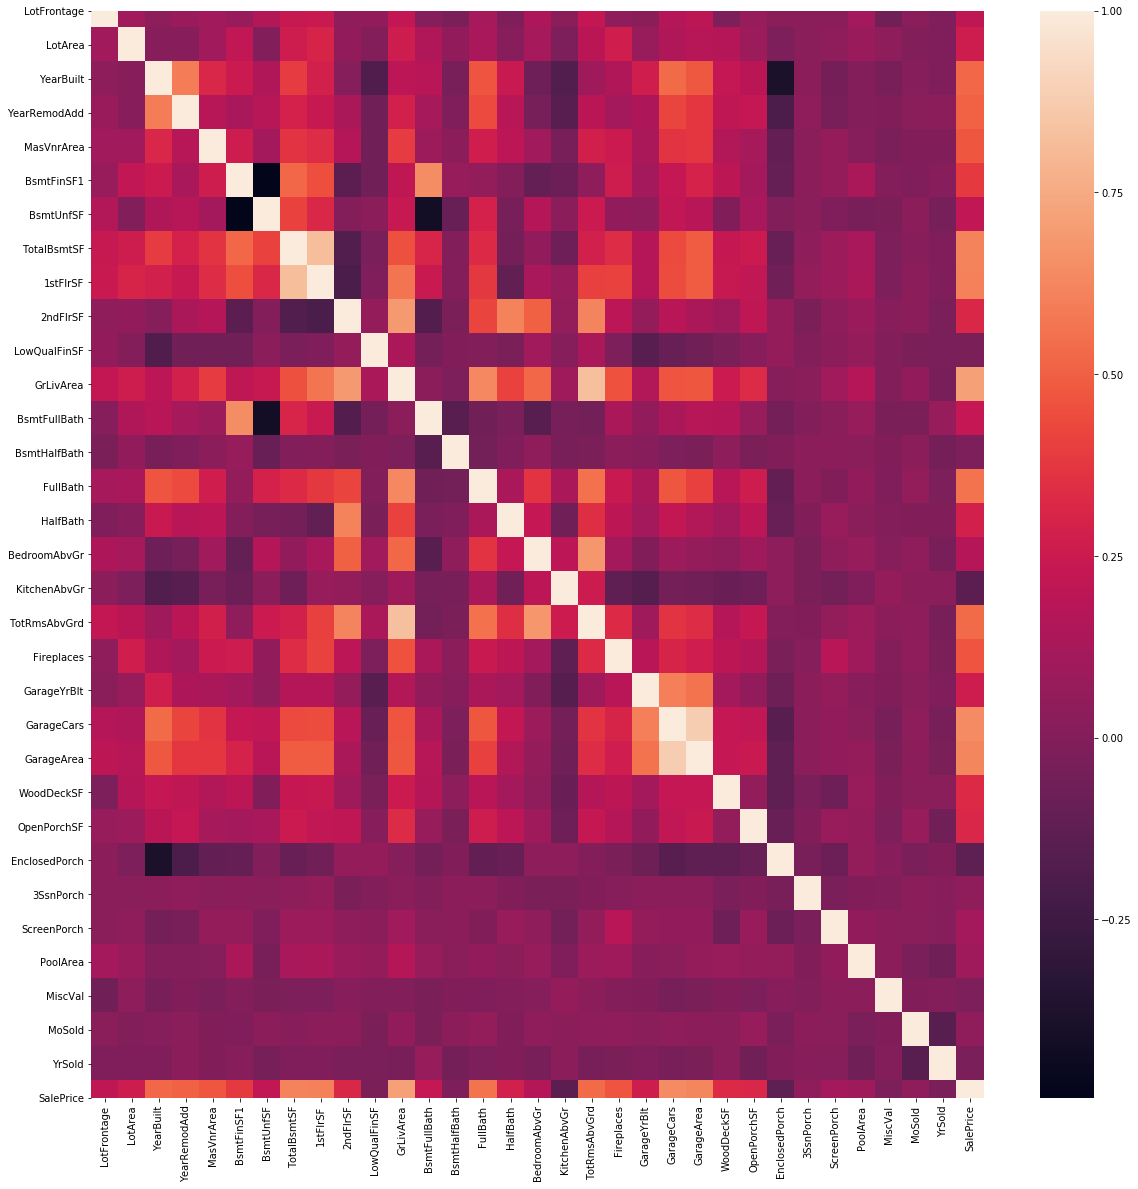

In [10]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[real_features + ['SalePrice']].corr())

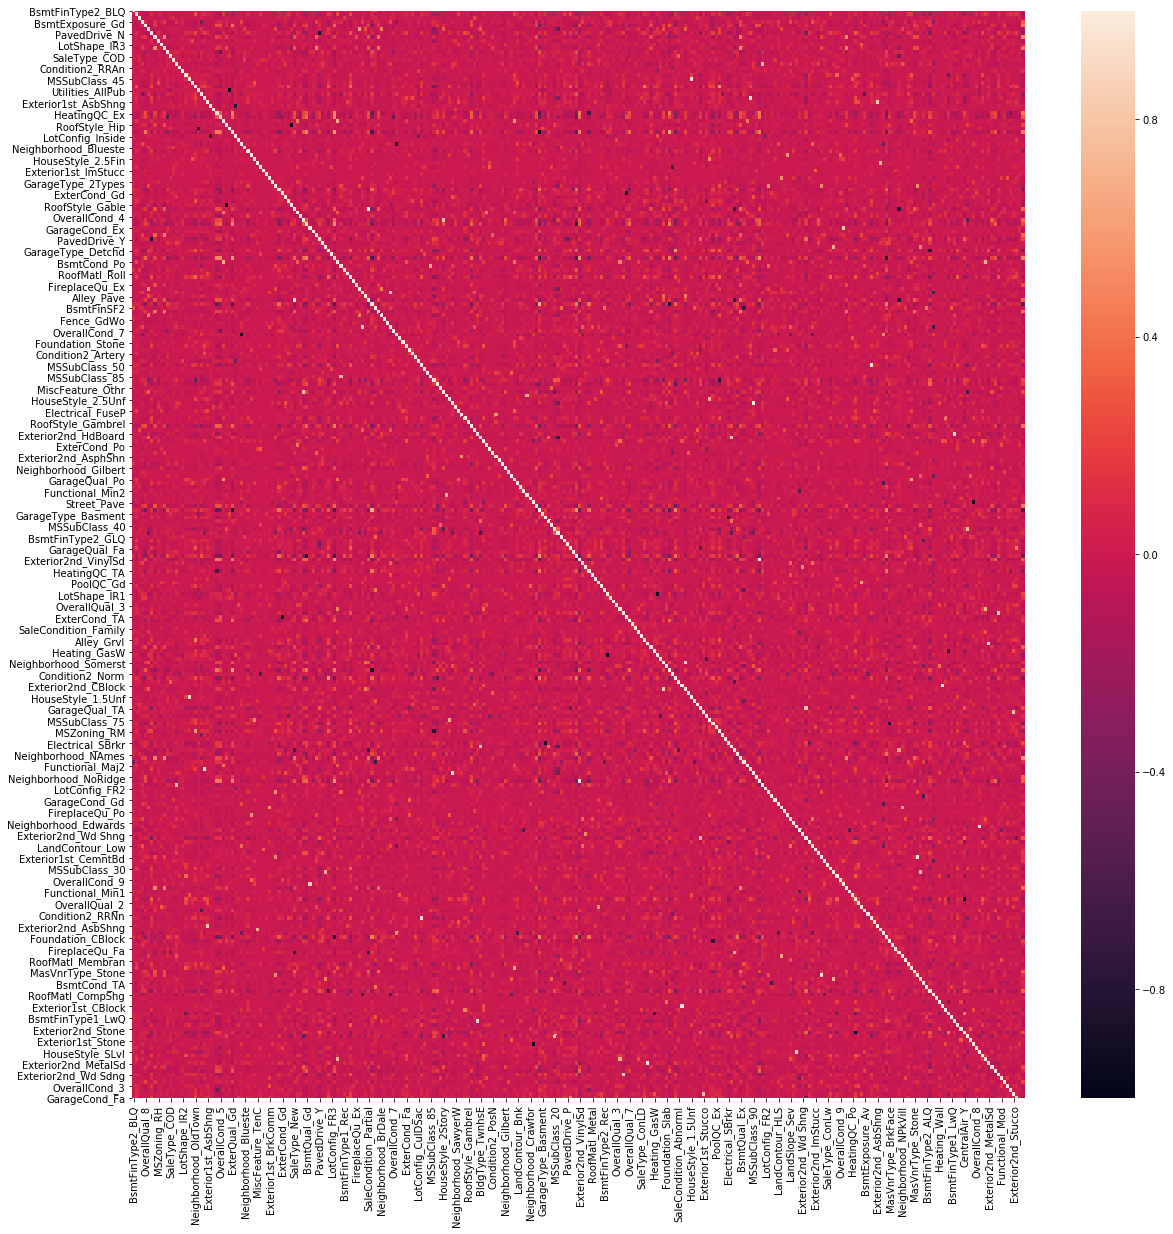

In [11]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[cat_features + ['SalePrice']].corr())

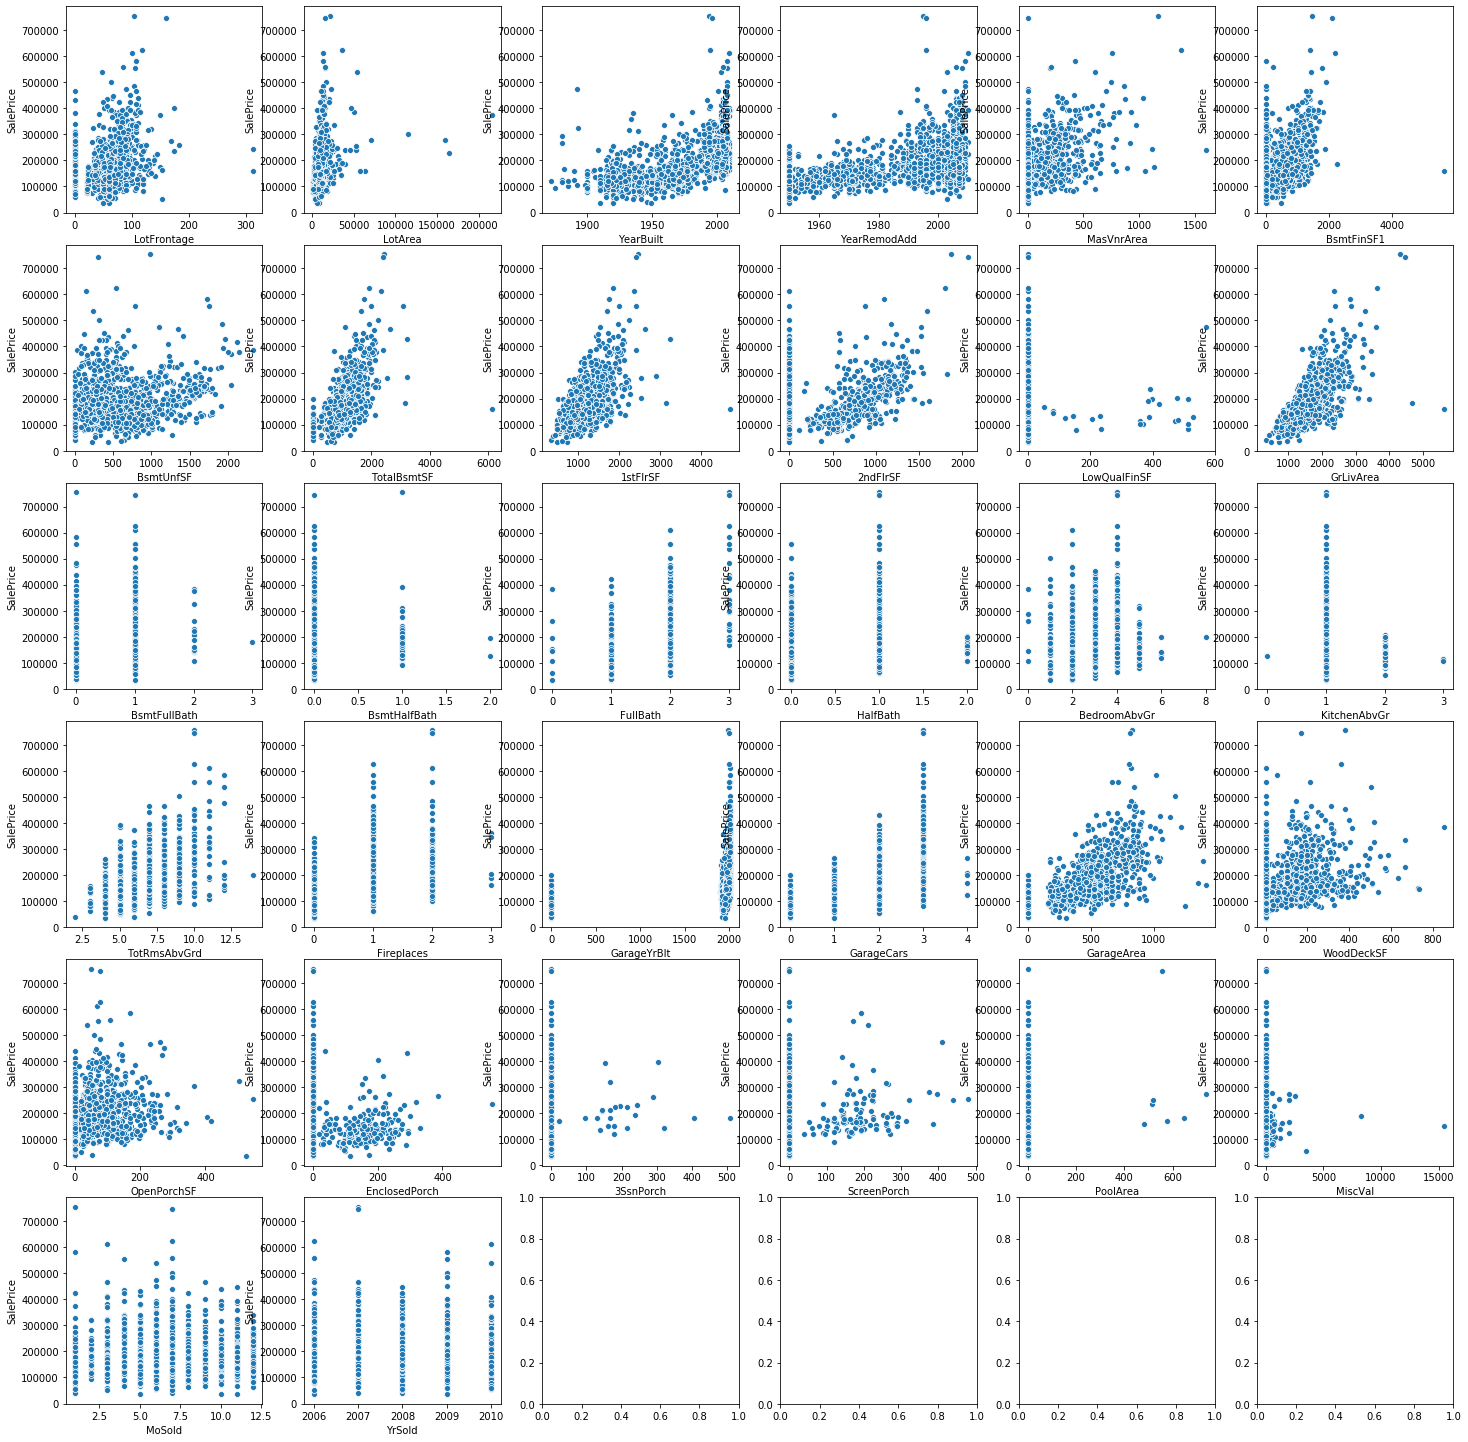

In [12]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout()
ax = iter(ax.flatten())
for feat in real_features:
    sns.scatterplot(x=feat, y='SalePrice', data=df, ax=next(ax))

In [13]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] 
y: 208500 


### Polynomial features

In [14]:
#transform = PolynomialFeatures(2)
#X_poly_real = transform.fit_transform(X_real)
X_poly_real = X_real

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_poly_real)

In [16]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 32)
(1460, 287)
(1460,)


### Checking dataset

In [17]:
X = np.hstack((X_real_scaled, X_cat))

In [18]:
xi = np.isfinite(X) 
print (xi[np.where(xi == False)].sum())

xn = np.isnan(X) 
print (xn[np.where(xn == False)].sum())

0
0


In [19]:
yi = np.isfinite(y) 
print (yi[np.where(yi == False)].sum())

yn = np.isnan(y) 
print (yn[np.where(yn == False)].sum())

0
0


## Features selection with Lasso

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score

In [21]:
param_grid = {
    'alpha': [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0], 'max_iter': [100000]
}
estimator = Lasso()

ls_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ls_model.fit(X, y)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0,
                                   130.0, 140.0, 150.0],
                         'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [22]:
print (ls_model.best_estimator_)

Lasso(alpha=150.0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [23]:
print (ls_model.best_score_)

0.8585782878828929


In [24]:
c = 0
not_null_idx = []
for cf in ls_model.best_estimator_.coef_:
    if cf != 0:
        not_null_idx.append(c)
    c += 1
print (len(not_null_idx))    
print (not_null_idx)    

91
[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 35, 36, 37, 39, 42, 48, 54, 59, 60, 67, 79, 83, 84, 86, 91, 97, 109, 110, 111, 114, 116, 124, 132, 133, 141, 148, 156, 160, 163, 168, 169, 173, 174, 176, 185, 192, 203, 208, 217, 219, 221, 227, 228, 229, 233, 235, 236, 245, 247, 255, 260, 262, 267, 276, 279, 282, 287, 294, 298, 301, 304, 313, 314, 317]


In [25]:
X = X[:, not_null_idx]
print (X.shape)

(1460, 91)


### SVR

In [26]:
from sklearn.svm import SVR

In [27]:
svr_model = SVR(kernel='linear', C=50.0, epsilon=1.0)

score = cross_val_score(svr_model, X, y, cv=10)
score_mean = score.mean()

In [28]:
print (score_mean)

0.7727633739854766


In [29]:
param_grid = {
    'kernel': ['linear'],
    'degree': [1],
    'C': [600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0],
    'epsilon': [0.01, 0.05, 0.1, 0.12]
}
estimator = SVR()

svr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
svr2_model.fit(X, y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 13.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0],
                         'degree': [1], 'epsilon': [0.01, 0.05, 0.1, 0.12],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [30]:
print (svr2_model.best_estimator_)

SVR(C=900.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.12,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


In [31]:
print (svr2_model.best_score_)

0.8613890066490761


## Linear regression

### Ridge

In [32]:
rg_model = Ridge(alpha=.5)

score = cross_val_score(rg_model, X, y, cv=10)
score_mean = score.mean()

In [33]:
print (score_mean)

0.8689882029711271


In [34]:
score = cross_val_score(rg_model, X, y, cv=5)
score_mean = score.mean()

In [35]:
print (score_mean)

0.8653739305996592


In [36]:
param_grid = {
    'alpha': [1., 1.2, 1.4, 1.6, 1.8, 2.0],
    'solver': ['auto', 'svd', 'cholesky']
}
estimator = Ridge()

rg2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rg2_model.fit(X, y)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.8s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
                         'solver': ['auto', 'svd', 'cholesky']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [37]:
print (rg2_model.best_estimator_)

Ridge(alpha=1.4, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='svd', tol=0.001)


In [38]:
print (rg2_model.best_score_)

0.8705699439353543


### ElasticNet

In [39]:
el_model = ElasticNet(alpha=.5, l1_ratio=.5, max_iter=100000)

score = cross_val_score(el_model, X, y, cv=10)
score_mean = score.mean()

In [40]:
print (score_mean)

0.8213793370980083


In [41]:
score = cross_val_score(el_model, X, y, cv=5)
score_mean = score.mean()

In [42]:
print (score_mean)

0.811781157710411


In [43]:
param_grid = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],               
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_iter': [100000]}
estimator = ElasticNet()

el2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
el2_model.fit(X, y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.0s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [44]:
print (el2_model.best_estimator_)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [45]:
print (el2_model.best_score_)

0.8705467198841466


### LassoLars

In [46]:
la_model = LassoLars(alpha=.5, max_iter=30)

score = cross_val_score(la_model, X, y, cv=10)
score_mean = score.mean()

In [47]:
print (score_mean)

0.8082032410935657


In [48]:
score = cross_val_score(la_model, X, y, cv=5)
score_mean = score.mean()

In [49]:
print (score_mean)

0.8056275705221472


In [50]:
param_grid = {
    'alpha': [1e-09, 0.00000001, 0.0000001, 0.000001, 0.00001], 
    'max_iter': [500, 400, 300, 200, 100]
}
estimator = LassoLars()

la2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
la2_model.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    7.3s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LassoLars(alpha=1.0, copy_X=True,
                                 eps=2.220446049250313e-16, fit_intercept=True,
                                 fit_path=True, max_iter=500, normalize=True,
                                 positive=False, precompute='auto',
                                 verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05],
                         'max_iter': [500, 400, 300, 200, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [51]:
print (la2_model.best_estimator_)

LassoLars(alpha=1e-09, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
          positive=False, precompute='auto', verbose=False)


In [52]:
print (la2_model.best_score_)

0.8567817947694231


## Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()

In [55]:
print (score_mean)

0.8134184103027001


In [56]:
param_grid = {
    'n_estimators': [250, 270, 300, 350, 400, 450], 
    'max_depth': [15, 16, 17, 18, 20],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
}
estimator = RandomForestRegressor()

rf2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rf2_model.fit(X, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [15, 16, 17, 18, 20

In [57]:
print (rf2_model.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [58]:
print (rf2_model.best_score_)


0.8620669125346504


## ExtraTrees

In [59]:
from sklearn.ensemble import ExtraTreesRegressor

In [60]:
etr_model = ExtraTreesRegressor(n_estimators=100)

score = cross_val_score(etr_model, X, y, cv=10)
score_mean = score.mean()

In [61]:
print (score_mean)

0.8514007719319865


In [62]:
param_grid = {
    'max_depth': [20, 22, 23, 24, 25],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': [20, 30, 50, 60, 70,80]
}
estimator = ExtraTreesRegressor()

etr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
etr2_model.fit(X, y)        

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators='warn', n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [20, 22, 23, 24, 25],
                         'min_samples_split': [2, 3, 4, 5],
   

In [63]:
print (etr2_model.best_estimator_)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=23,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=4,
                    min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)


In [64]:
print (etr2_model.best_score_)

0.854890087430576


## AdaBoost

In [65]:
#from sklearn.ensemble import AdaBoostRegressor

In [66]:
#ada_model = AdaBoostRegressor(n_estimators=100)

#score = cross_val_score(ada_model, X, y, cv=10)
#score_mean = score.mean()

In [67]:
#print (score_mean)

In [68]:
#param_grid = {
#    'loss': ['linear', 'square', 'exponential'],
#    'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.6, 0.7, 0.8, 1.],
#    'n_estimators': [ 40, 50, 60, 70, 100]
#}
#estimator = AdaBoostRegressor()

#ada2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
#ada2_model.fit(X, y)        

In [69]:
#print (ada2_model.best_estimator_)

In [70]:
#print (ada2_model.best_score_)

## GradientBoosting

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

In [72]:
gb_model = GradientBoostingRegressor(n_estimators=100)

score = cross_val_score(gb_model, X, y, cv=10)
score_mean = score.mean()

In [73]:
print (score_mean)

0.8797891918942857


In [74]:
param_grid = {
    'learning_rate': [0.07, 0.1, 0.12],
    'max_depth': [3, 4, 5],
    'min_samples_split': [17, 18, 20, 21, 22, 23],
    'n_estimators': [450, 500, 550, 600, 650]
}
estimator = GradientBoostingRegressor()

gb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
gb2_model.fit(X, y)        

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 12.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                             

In [75]:
print (gb2_model.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=20,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [76]:
print (gb2_model.best_score_)

0.9020499990566171


## XGBoost

In [77]:
from xgboost import XGBRegressor

In [78]:
xgb_model = XGBRegressor()

score = cross_val_score(xgb_model, X, y, cv=10)
score_mean = score.mean()

[16:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [79]:
print (score_mean)

0.8733010990051502


In [80]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [2, 3, 4],
    'gamma': [0.06, 0.08, 0.1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
    'n_estimators': [700, 800, 850, 900]
}
estimator = XGBRegressor()

xgb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
xgb2_model.fit(X, y)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 21.4min finished


[16:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7],
                         'gamma': [0.06, 0.1, 0.2],
         

In [81]:
print (xgb2_model.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.06,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=800,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [82]:
print (xgb2_model.best_score_)

0.8962424794932671


## Voting

In [83]:
from sklearn.ensemble import VotingRegressor

In [109]:
best_models = [
    #('ls', ls_model), 
    #('svr', svr2_model),
    ('rg', rg2_model),   
    ('el', el2_model), 
    #('la', la2_model),
    #('rf', rf2_model),    
    #('etr', etr2_model),
    ('gb', gb2_model),
    ('xgb', xgb2_model),
    #('ada', ada2_model),
]
best_estimators = []
for md in best_models:
    print ("{}_model: {}".format(md[0], md[1].best_score_))
    best_estimators.append((md[0], md[1].best_estimator_))

rg_model: 0.8705699439353543
el_model: 0.8705467198841466
gb_model: 0.9020499990566171
xgb_model: 0.8962424794932671


In [110]:
vt_model = VotingRegressor(best_estimators, n_jobs=-1)

print (vt_model)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=1.4, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='svd',
                                   tol=0.001)),
                            ('el',
                             ElasticNet(alpha=0.001, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.1,
                                        max_iter=100000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
                                        tol=0.0001, warm_start=...
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.5, gamma=0.06,
                                 

In [111]:
score = cross_val_score(vt_model, X, y, cv=10)
score_mean = score.mean()

In [112]:
print (score_mean)

0.9028158524995303


In [113]:
vt_model.fit(X, y)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=1.4, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='svd',
                                   tol=0.001)),
                            ('el',
                             ElasticNet(alpha=0.001, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.1,
                                        max_iter=100000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
                                        tol=0.0001, warm_start=...
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.5, gamma=0.06,
                                 

In [114]:
print (len(vt_model.estimators))

4


### LR submission

In [115]:
df_train = df.copy()

df = pd.read_csv('./test.csv')
house_ids = df['Id'].to_numpy()
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [116]:
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,1,0,0,0,0,1,0
1,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,...,0,0,0,1,0,0,0,0,1,0
2,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,928,...,0,0,0,1,0,0,0,0,1,0
3,78.0,9978,1998,1998,20.0,602.0,0.0,324.0,926.0,926,...,0,0,0,1,0,0,0,0,1,0
4,43.0,5005,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,0,0,1,0,0,0,0,1,0


In [117]:
features_diff = list(set(df_train.columns.values.tolist()) - set(df.columns.values.tolist()))
print (len(features_diff), features_diff)
zeros = np.zeros(df.shape[0])

for ft in features_diff:
    df[ft] = pd.Series(zeros)

18 ['Exterior1st_Stone', 'RoofMatl_Roll', 'GarageQual_Ex', 'Condition2_RRAe', 'RoofMatl_ClyTile', 'Electrical_Mix', 'Condition2_RRAn', 'HouseStyle_2.5Fin', 'Utilities_NoSeWa', 'RoofMatl_Membran', 'Condition2_RRNn', 'MiscFeature_TenC', 'Exterior1st_ImStucc', 'Heating_Floor', 'RoofMatl_Metal', 'Heating_OthW', 'PoolQC_Fa', 'Exterior2nd_Other']


In [118]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1232.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,68.580357,9819.161069,1971.357779,1983.662783,100.709141,439.203704,554.294925,1046.117970,1156.534613,325.967786,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,22.376841,4955.517327,30.390071,21.130467,177.625900,455.268042,437.260486,442.898624,398.165820,420.610226,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,21.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,58.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,67.000000,9399.000000,1973.000000,1992.000000,0.000000,350.500000,460.000000,988.000000,1079.000000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11517.500000,2001.000000,2004.000000,164.000000,753.500000,797.750000,1305.000000,1382.500000,676.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,2140.000000,5095.000000,5095.000000,1862.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [119]:
df[cat_features].describe()

,BsmtFinType2_BLQ,BsmtQual_Fa,MasVnrType_BrkCmn,BsmtExposure_Gd,OverallQual_8,MSSubClass_160,PavedDrive_N,KitchenQual_Ex,MSZoning_RH,LotShape_IR3,...,GarageType_BuiltIn,Neighborhood_CollgCr,Exterior2nd_Wd Sdng,Functional_Mod,Neighborhood_StoneBr,OverallCond_3,HeatingQC_Gd,Exterior2nd_Stucco,GarageCond_Fa,MiscFeature_Shed
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.023989,0.036326,0.006854,0.097327,0.119260,0.044551,0.086361,0.071967,0.006854,0.004112,...,0.067169,0.080192,0.132968,0.013708,0.017820,0.017135,0.159698,0.014393,0.026731,0.031528
std,0.153067,0.187165,0.082533,0.296504,0.324205,0.206387,0.280992,0.258522,0.082533,0.064018,...,0.250401,0.271683,0.339656,0.116316,0.132344,0.129819,0.366452,0.119147,0.161350,0.174801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
print (df.shape)

(1459, 320)


In [121]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0) 

In [122]:
X_testing_real = df[real_features].to_numpy()
X_testing_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_testing_real[0]))
print ("X_cat: {} ".format(X_testing_cat[0]))

X_real: [8.0000e+01 1.1622e+04 1.9610e+03 1.9610e+03 0.0000e+00 4.6800e+02
 2.7000e+02 8.8200e+02 8.9600e+02 0.0000e+00 0.0000e+00 8.9600e+02
 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
 5.0000e+00 0.0000e+00 1.9610e+03 1.0000e+00 7.3000e+02 1.4000e+02
 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+02 0.0000e+00 0.0000e+00
 6.0000e+00 2.0100e+03] 
X_cat: [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   1. 144.   0.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [123]:
#X_testing_poly_real = transform.fit_transform(X_testing_real)
X_testing_poly_real = X_testing_real

In [124]:
X_testing_real_scaled = scaler.fit_transform(X_testing_poly_real)

In [125]:
X_testing = np.hstack((X_testing_real_scaled, X_testing_cat))

X_testing = X_testing[:, not_null_idx]
print (X_testing.shape)

(1459, 91)


In [126]:
predicted = vt_model.predict(X_testing)

print (predicted)
print (house_ids)

[117354.26761173 153696.93867848 189547.5997199  ... 159722.44964837
 119800.93241369 219377.53226663]
[1461 1462 1463 ... 2917 2918 2919]


In [127]:
with open("submission_vt6.txt", "w") as fout:
    fout.write("Id,SalePrice\n")
    for val in zip(house_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))